# Aprendizado de máquina - TP 2
## Pedro Tavares de Carvalho
Para o segundo trabalho prático da disciplina de aprendizado de máquina, foi pedida a implementação e análise de uma rede neural convolucional e de um processo de transferência de aprendizado.  

Essa análise será feita utilizando `tensorflow` e `keras`, além de `pandas` e `numpy` para a formatação e visualização dos dados.

O primeiro o passo para a realização do trabalho será importar as bibliotecas necessárias. O `tensorflow` é uma biblioteca de representação numérica que toma proveito da aceleração de computação de placas de vídeo, além de possuir representações de gradiente e backward propagation implementadas na biblioteca em si. Isso a torna extremamente conveniente para a representação de redes neurais.

A biblioteca `keras` é uma biblioteca que fornece modelos de redes neurais e de otimizadores que usam o `tensorflow` para a montagem da rede e de seus parâmetros.

In [2]:
import tensorflow as tf # Tensorflow para representação dos dados em tensores
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Dados e camadas de redes neurais do keras
from tensorflow import keras

# Bibliotecas de manipulação de dados
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Depois de importar a biblioteca, baixamos os dados que serão usados para o treinamento da rede neural. No caso desse trabalho, o banco de dados usado será o `CIFAR10`, que são imagens de 10 classes diferentes e cujo banco de dados está disponível para download pelo `keras`, facilitando a aquisição dos dados.


In [3]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

Definindo os nomes das classes que serão classificadas pelo modelo e o formato das imagens.

In [10]:
classes = ('Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

imgFormat = train_x[1:]

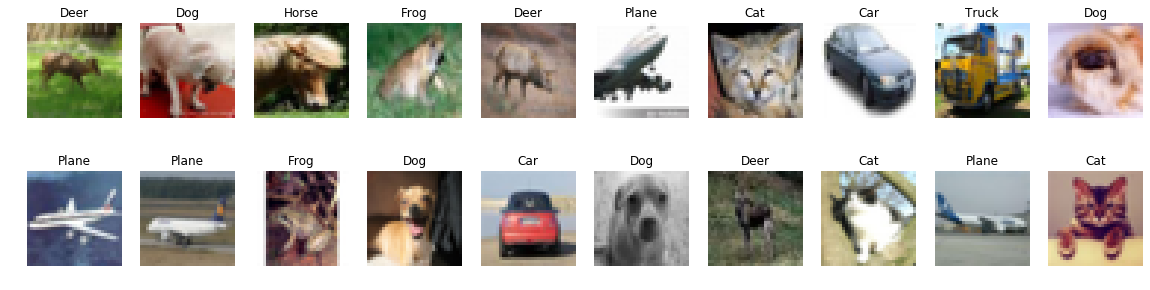

In [5]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, train_x.shape[0])
        axes[i][j].imshow(train_x[img_i], cmap="gray")
        axes[i][j].set_title("{}".format(classes[int(train_y[img_i])]))
        axes[i][j].axis("off")
plt.show()

O primeiro passo é normalizar as entradas e separar a saída em classes diferentes para permitir a classificação por redes neurais.

In [6]:
train_y = train_y/255
test_y = test_y/255
train_y = pd.get_dummies(train_y[:, 0]).values
test_y = pd.get_dummies(test_y[:, 0]).values

Como faremos o *transfer learning*, os dados serão separados em dois grupos, e, como determinado pela especificação, um dos grupos será com as classes 4 e 9, e o outro com as outras classes, visto que o meu número de matrícula é 2017014499.

In [7]:
train_x_b = np.array([train_x[i] for i in range(len(train_y)) if train_y[i][4] == 1 or train_y[i][9] == 1])
train_x_a = np.array([train_x[i] for i in range(len(train_y)) if not(train_y[i][4] == 1 or train_y[i][9] == 1)])
train_y_b = np.array([train_y[i] for i in range(len(train_y)) if train_y[i][4] == 1 or train_y[i][9] == 1])
train_y_a = np.array([train_y[i] for i in range(len(train_y)) if not(train_y[i][4] == 1 or train_y[i][9] == 1)])

test_x_b = np.array([test_x[i] for i in range(len(test_y)) if test_y[i][4] == 1 or test_y[i][9] == 1])
test_x_a = np.array([test_x[i] for i in range(len(test_y)) if not(test_y[i][4] == 1 or test_y[i][9] == 1)])
test_y_b = np.array([test_y[i] for i in range(len(test_y)) if test_y[i][4] == 1 or test_y[i][9] == 1])
test_y_a = np.array([test_y[i] for i in range(len(test_y)) if not(test_y[i][4] == 1 or test_y[i][9] == 1)])

Depois de separados os dados e as classes transformadas em arrays de classes, normalizamos as entradas da rede neural.

In [8]:
print(train_y_b.shape, train_y_a.shape)

(10000, 10) (40000, 10)


## A rede neural
A rede neural especificada possui quatro camadas de convolução 2D e duas camadas de *Max Pool*. A ordem dessas camadas foi deixada para determinação do aluno. 

Por experimentação, a ordem decidida foi:


`Input -> Conv1 -> Conv2 -> Pool1 -> Conv3 -> Conv4 -> Pool2 -> Flatten -> Dense1 -> Dropout -> Dense2 -> Output`

O número de filtros de convolução foi de 32 na camada `Conv1`, duplicando o número de filtros a cada camada de convolução. Também por experimentação, o dropout condizente à camada é por volta de 0.85.

![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/diagram.png)

In [9]:
convSize = 32 # número de filtros de convolução na primeira camada
drop = 0.85 # Rate de dropout

In [0]:
def startModel():
    # Camada de entrada do modelo
    model_input = keras.layers.Input(
        shape=imgFormat, 
        name='Input')

    # Primeira camada de convolução, com 'convSize' filtros
    x = keras.layers.Conv2D(
        convSize, 
        kernel_size=(3,3), 
        activation='relu', 
        padding='same', 
        name='Conv1')(model_input)

    # Segunda camada de convolução, com 2*convSize filtros
    x = keras.layers.Conv2D(
        convSize*2, 
        kernel_size=(3,3), 
        activation='relu', 
        padding='same', 
        name='Conv2')(x)

    # Primeira camada de Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        name="Pool1")(x)

    # Terceira camada de convolução, com 4*convSize filtros
    x = keras.layers.Conv2D(
        convSize*4,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        name='Conv3')(x)

    # Quarta camada de convolução, com 8*convSize filtros
    x = keras.layers.Conv2D(
        convSize*8, 
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        name='Conv4')(x)

    # Segunda camada de Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2), 
        name="Pool2")(x)

    # Camada de "linearização" dos parâmetros para um vetor unidimensional
    x = keras.layers.Flatten(
        name="Flatten")(x)

    # Camada fully connected
    x = keras.layers.Dense(
        128, 
        activation="relu", 
        name="Dense1")(x)

    # Camada de regularização, com probabilidade de dropout 'drop'
    x = keras.layers.Dropout(
        drop, 
        name="Dropout")(x)

    # Camada final de classificação
    model_output = keras.layers.Dense(
        len(classes), 
        activation='softmax', 
        name="Output")(x)

    # junção do modelo completo
    return keras.models.Model(model_input, model_output)


W0624 22:24:41.594596 140411702814592 nn_ops.py:4230] Large dropout rate: 0.885 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


## O treinamento para os rótulos do grupo `A`
Com esse formato de modelo, o próximo passo é a compilação e o treinamento do mesmo. O *learning rate* que melhor funcionou para esse modelo foi entre $0.001$ e $0.003$. Decidi usar $0.003$ pois a convergência do modelo é mais rápida, e como o otimizador *Adam* adapta o *learning rate* a medida da época do treinamento, isso evita a divergência em estados mais avançados do gradiente.

In [0]:
modelA = startModel()

optimizer = keras.optimizers.Adam(
    lr=0.003)

modelA.compile(
    optimizer,
    loss="categorical_crossentropy", 
    metrics=["accuracy"])

historyA = modelA.fit(
    train_x_a,
    train_y_a,
    batch_size=128,
    epochs=20,
    validation_data=(
        test_x_a, 
        test_y_a)
    )

W0624 22:24:44.978954 140411702814592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 22:24:45.143696 140411702814592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 40000 samples, validate on 8000 samples
Epoch 1/20
  128/40000 [..............................] - ETA: 24:18 - loss: 2.3007 - accuracy: 0.0703

W0624 22:24:50.234730 140411702814592 callbacks.py:242] Method (on_train_batch_end) is slow compared to the batch update (0.318064). Check your callbacks.


40000/40000 [==============================] - 9s 234us/sample - loss: 1.8948 - accuracy: 0.2562 - val_loss: 1.4022 - val_accuracy: 0.5210
Epoch 2/20
40000/40000 [==============================] - 4s 108us/sample - loss: 1.6288 - accuracy: 0.3394 - val_loss: 1.2314 - val_accuracy: 0.5586
Epoch 3/20
40000/40000 [==============================] - 4s 107us/sample - loss: 1.5240 - accuracy: 0.3814 - val_loss: 1.1589 - val_accuracy: 0.5769
Epoch 4/20
40000/40000 [==============================] - 4s 107us/sample - loss: 1.4419 - accuracy: 0.4151 - val_loss: 1.0471 - val_accuracy: 0.6428
Epoch 5/20
40000/40000 [==============================] - 4s 107us/sample - loss: 1.3702 - accuracy: 0.4484 - val_loss: 1.0181 - val_accuracy: 0.6403
Epoch 6/20
40000/40000 [==============================] - 4s 108us/sample - loss: 1.3149 - accuracy: 0.4732 - val_loss: 0.9792 - val_accuracy: 0.6639
Epoch 7/20
40000/40000 [==============================] - 4s 107us/sample - loss: 1.2662 - accuracy: 0.4913 - v

Como é perceptível no gráfico abaixo, a acurácia de treino e de validação aumenta constantemente durante as épocas, enquanto suas funções de perda diminuem. 

A convergência da acurácia de treino e de validação para o mesmo número mostra que o modelo também está regularizado, visto que os sintomas de *overfitting* não estão presentes, como a diminuição do erro de treino e o aumento ou a paralização do erro de validação.

In [ ]:
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
        label="Train Loss", color="royalblue", lw=3)

axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
        label="Validation Loss", color="forestgreen", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["acc"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
        label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
        label="Teste ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["acc"])+1))
axes[1].legend()
plt.show()

## Modelo para o treinamento com os rótulos do grupo `B`
Para o grupo B, o trabalho especificou três redes diferentes, com técnicas de treinamento diferentes, sendo a primeira o treinamento desde a primeira camada, a segunda com *fine tuning* da última camada, e a terceira com *fine tuning* de duas camadas, sendo as últimas duas práticas da prática do *Transfer Learning*.
### O modelo sem *Transfer Learning*
Para o treinamento do primeiro modelo com os rótulos `B`, não farei nenhuma mudança na rede neural, continuando com os mesmos hiperparâmetros e a mesma disposição da rede `A`.

![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/diagram.png)

In [0]:
modelB = startModel()
optimizerB = optimizers.Adam(lr=0.001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
modelB.compile(optimizerB, loss="categorical_crossentropy", metrics=["accuracy"])

# Treina por 10 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
historyB = modelB.fit(train_x_b, train_y_b, batch_size=128, epochs=20, validation_data=(test_x_b, test_y_b))


W0621 15:51:31.775789 139728939796352 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 143us/step - loss: 0.5966 - acc: 0.7578 - val_loss: 0.2309 - val_acc: 0.9090
Epoch 2/20
10000/10000 [==============================] - 1s 78us/step - loss: 0.2764 - acc: 0.8994 - val_loss: 0.2241 - val_acc: 0.9135
Epoch 3/20
10000/10000 [==============================] - 1s 79us/step - loss: 0.2421 - acc: 0.9129 - val_loss: 0.1667 - val_acc: 0.9370
Epoch 4/20
10000/10000 [==============================] - 1s 79us/step - loss: 0.2359 - acc: 0.9142 - val_loss: 0.1930 - val_acc: 0.9270
Epoch 5/20
10000/10000 [==============================] - 1s 78us/step - loss: 0.2026 - acc: 0.9275 - val_loss: 0.1800 - val_acc: 0.9290
Epoch 6/20
10000/10000 [==============================] - 1s 79us/step - loss: 0.1888 - acc: 0.9326 - val_loss: 0.1477 - val_acc: 0.9455
Epoch 7/20
10000/10000 [==============================] - 1s 82us/step - loss: 0.1830 - acc: 0.9346 - val_loss: 0.1308 - val_acc

In [0]:
modelBA1 = startModel(0.75)
modelBA1.set_weights(modelA.get_weights())

for layer in modelBA1.layers[:-1]:
  layer.trainable = False
modelBA1.summary()

W0621 15:52:02.228303 139728939796352 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 8)         224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 16)        1168      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 32)        4640      
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

In [0]:
optimizerBA1 = optimizers.Adam(lr=0.001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
modelBA1.compile(optimizerBA1, loss="categorical_crossentropy", metrics=["accuracy"])

# Treina por 10 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
history = modelBA1.fit(train_x_b, train_y_b, batch_size=128, epochs=20, validation_data=(test_x_b, test_y_b))


Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 94us/step - loss: 11.6290 - acc: 8.0000e-04 - val_loss: 10.8888 - val_acc: 0.0000e+00
Epoch 2/20
10000/10000 [==============================] - 1s 56us/step - loss: 8.5123 - acc: 0.0068 - val_loss: 5.8393 - val_acc: 0.0000e+00
Epoch 3/20
10000/10000 [==============================] - 1s 55us/step - loss: 3.8244 - acc: 0.1719 - val_loss: 1.3626 - val_acc: 0.5260
Epoch 4/20
10000/10000 [==============================] - 1s 57us/step - loss: 1.4216 - acc: 0.5665 - val_loss: 0.5447 - val_acc: 0.8400
Epoch 5/20
10000/10000 [==============================] - 1s 55us/step - loss: 0.8919 - acc: 0.7371 - val_loss: 0.3636 - val_acc: 0.8940
Epoch 6/20
10000/10000 [==============================] - 1s 57us/step - loss: 0.6628 - acc: 0.7990 - val_loss: 0.2950 - val_acc: 0.9165
Epoch 7/20
10000/10000 [==============================] - 1s 56us/step - loss: 0.5551 - acc: 0.8374 - val_loss: 0.2